In [1]:
#Leer imagenes satelitales (.nc)
from netCDF4 import Dataset, num2date

#Graficos y visualizaciones
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

#Liberias estandar
import pandas as pd
import re
import numpy as np
import time
import os

In [2]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
path_base = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis'

In [3]:
"""
Metodos para realizar las estadisticas de los datos de precipitacion
"""

'\nMetodos para realizar las estadisticas de los datos de precipitacion\n'

In [4]:
#Convierte una fecha de formato year-month-day-hour en un numero
def fechaInt(fechaStr):
    x = fechaStr.split('-')
    year = x[0][2:]
    return (int(year)*1000000) + (int(x[1])*10000)  + (int(x[2])*100) + int(x[3])

In [5]:
#Realiza un grafico de dispersion (Tipo = 1) o boxplit (Tipo = 2)
def Grafico(df,filename,tipo):    
    x = df.index
    y = df['dato']   
    
    if tipo==1:
        plt.clf()
        plt.scatter(x=x,y=y, alpha=0.1)
    if tipo==2:
        plt.clf()
        plt.boxplot(x=y)
        
    plt.xlabel("Indices")
    plt.ylabel("Precipitacion (mm/h)")
    plt.title(f"{filename.split('/')[-1][:-4]}")
    plt.axhline(y=y.quantile(0.99), color='r', linestyle='-')
    
    plt.savefig(filename)
    plt.clf()
    #plt.show()

    return True

In [6]:
#Elimina los vamos no alfanumericos de un string 
def quitaNoAlfaNum(texto):
    import re
    texto = texto.replace(' ',"")
    return re.compile(r'\W+', re.UNICODE).split(texto)

In [7]:
#Por cada estacion se hallara:
#- Cantidad de datos,- Promedio,- Varianza,- Valor min ,- Valor max
#- Fecha minima,- Fecha Maxima,- Cantidad de datos atipicos (Mayores a 99%)
#- Cantidad de NA,- Cantidad de ceros

#Graficos
#- Boxplot,- Dispersion
def resumenStats(path_base,estacionesF,datosF,year,grafico=0):
    stations = pd.read_csv(estacionesF)
    datos = pd.read_csv(datosF,encoding='latin-1')    
    #Creamos la carpeta plots para los graficos
    try:
        path = os.path.join(f'{path_base}', 'Reportes')
        os.mkdir(path)        
    except FileExistsError:
        pass
    
    start_time = time.time() 
    resultado = []
    
    #Auxiliares    
    total = len(stations.index)
    completados = 1 
    
    #Por cada estacion se realizara lso graficos
    for i in stations.index:    
        station = stations['ESTACION'][i]
        code = stations['CODE'][i]
        LON = stations['LON'][i]
        LAT = stations['LAT'][i]
        ALT = stations['ALT'][i]
        
        


        tempDato = datos.loc[datos['NOMBRE']==station]    
        cantNA = tempDato.loc[tempDato['PRECIPITACION'].isna()].count()[0]

        #Eliminamos todos los NA antes de realizar las estadisticas        
        tempDato = tempDato.dropna(axis='index',subset=['PRECIPITACION'])   
        
        #Eliminamos los valores valores mayor a 1k o menor a 1k
        tempDato = tempDato[tempDato['PRECIPITACION']<=100]
        tempDato = tempDato[tempDato['PRECIPITACION']>=0]


        stats = tempDato['PRECIPITACION'].describe()
        stats = stats.to_dict()    
        fmin = tempDato['FECHA'].min()
        fmax = tempDato['FECHA'].max()    
        stats['FechaMax'] = fmax
        stats['count'] = int(stats['count'])
        stats['FechaMin'] = fmin    
        stats['Nombre'] = station
        stats['Codigo'] = code
        stats['ceros'] = tempDato.loc[tempDato['PRECIPITACION']==0].count()[0]
        stats['NA'] = cantNA


        stats['75mayor'] = tempDato.loc[tempDato['PRECIPITACION']>stats['75%']].count()[0]
        stats['90mayor'] = tempDato.loc[tempDato['PRECIPITACION']>tempDato['PRECIPITACION'].quantile(0.90)].count()[0]
        stats['90%'] =  tempDato['PRECIPITACION'].quantile(0.90)
        stats['99mayor'] = tempDato.loc[tempDato['PRECIPITACION']>tempDato['PRECIPITACION'].quantile(0.99)].count()[0]
        stats['99%'] =  tempDato['PRECIPITACION'].quantile(0.99)
        stats['LON'] = LON
        stats['LAT'] = LAT
        stats['ALT'] = ALT
        resultado.append(stats)
        
        if grafico:
            Grafico(tempDato,f'{path_plot}/{code}_scatter.png',1)   
            Grafico(tempDato,f'{path_plot}/{code}_box.png',2)   
        
        completados = completados +1
        if not completados % 50:
            progreso = completados/total*100
            f = '{0:.3g}'.format(progreso)
            print(f"Procesando - {f}%")
            

    print("Time taken: %.2fs" % (time.time() - start_time)) 
    
    #Borramos las estaciones que no tengan datos
    df = pd.DataFrame(resultado)
    df = df[df['count']!=0]

    #Guardamso las estadisticas
    df = df.astype({"count":int})
    df.to_csv(f'{path_base}/Archivos/Reportes/analisis_{year}.csv',index=False)

    return resultado


In [8]:
listaFases = [
    'ND',    'C0000001',    'M0000001',    'M0000001, M0110302' ,    'M0110302',
    'D0210301',    'D0210302',    'D0210303',    'D0210304',    'D0220301',
    'D0230301',    'D0230302',    'D0230303',    'D0230304',    'C0000002',
    'DIM00001',    'M0000002'
]
dfFases = pd.DataFrame({'FLAG' : listaFases})
dfFases = dfFases.reset_index().set_index('FLAG')

In [20]:
"""
Realizamos las metricas por estacionara cada archivo (año)
"""

'\nRealizamos las metricas por estacionara cada archivo (año)\n'

In [15]:
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
Fdatos2021 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2021.csv'
Fdatos2020 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2020.csv'

#Eliminan malos en Etapa 1
eliminarFG = [0,2,3,4]

In [44]:
#Revisamos la cantidad de datos por flag
#Año 2020
dfFlags20 = pd.read_csv(Fdatos2020,encoding='latin-1')
flagsDF20 = dfFlags20.groupby(['FLAG'], dropna = False).size().reset_index(name='Cantidad')
flagsDF20['Fase'] = flagsDF20['FLAG'].map(dfFases['index'])
flagsDF20 = flagsDF20.sort_values(by=['Fase'])

#Quitamos los flag 'M...' y 'ND'
noND20 = flagsDF20[~flagsDF20['Fase'].isin(eliminarFG)]
noND20


,FLAG,Cantidad,Fase
0,C0000001,1139616,1
2,D0220301,10402,9
3,D0230301,8883,10
4,D0230303,14632,12
1,C0000002,4588,14
5,DIM00001,2,15
8,M0000002,133,16


In [45]:
#Revisamos la cantidad de datos por flag
#Año 2021
valores2021 = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/SENAMHI/Datasets/REPORTE_SGD_2021.csv'
dfFlags21 = pd.read_csv(Fdatos2021,encoding='latin-1')
flagsDF21 = dfFlags21.groupby(['FLAG'], dropna = False).size().reset_index(name='Cantidad')
flagsDF21['Fase'] = flagsDF21['FLAG'].map(dfFases['index'])
flagsDF21 = flagsDF21.sort_values(by=['Fase'])

#Quitamos los flag 'M...' y 'ND'
noND21 = flagsDF21[~flagsDF21['Fase'].isin(eliminarFG)]
noND21

,FLAG,Cantidad,Fase
0,C0000001,1738257,1
2,D0220301,14342,9
3,D0230301,12557,10
4,D0230303,11194,12
1,C0000002,53776,14
7,M0000002,8414,16


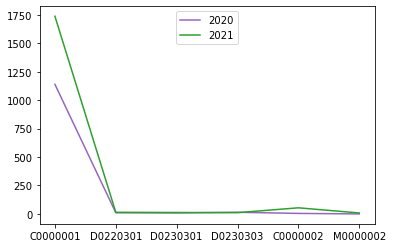

In [50]:
#Graficamos los FLAGS
ejeX = dfFases[~dfFases['index'].isin(eliminarFG)]

ejeY = ejeX.merge(noND20, on='FLAG', how='left')
ejeY = ejeY.merge(noND21, on='FLAG',suffixes=('_20', '_21'))


fig, ax = plt.subplots()

ax.plot(ejeY['FLAG'], ejeY['Cantidad_20']/1000, color = 'tab:purple', label="2020")
ax.plot(ejeY['FLAG'], ejeY['Cantidad_21']/1000, color = 'tab:green', label="2021")
plt.legend(loc="upper center")
plt.show()

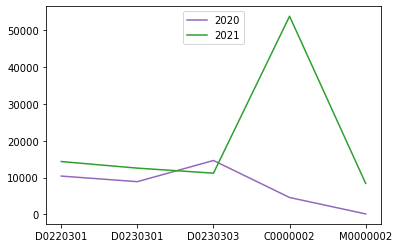

In [51]:
#Graficamos sin C000001
fig, ax = plt.subplots()

ejeY_noC1 = ejeY.drop(index=ejeY.index[0], axis=0)

ax.plot(ejeY_noC1['FLAG'], ejeY_noC1['Cantidad_20'], color = 'tab:purple', label="2020")
ax.plot(ejeY_noC1['FLAG'], ejeY_noC1['Cantidad_21'], color = 'tab:green', label="2021")
plt.legend(loc="upper center")
plt.show()

<AxesSubplot:>

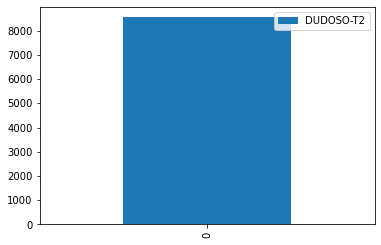

In [87]:
JoinDF = {}
#JoinDF['DUDOSO-T1'] = [ejeY[ejeY['FLAG'].str.startswith('D')].loc[:,['Cantidad_20','Cantidad_21']].sum().sum()]
#JoinDF['CONFORME-T2'] = [ejeY[ejeY['FLAG']=='C0000002'].loc[:,['Cantidad_20','Cantidad_21']].sum().sum()]
JoinDF['DUDOSO-T2'] = [ejeY[ejeY['FLAG'].str.startswith('M')].loc[:,['Cantidad_20','Cantidad_21']].sum().sum()]
#JoinDF['CONFORME-T1'] = [ejeY[ejeY['FLAG']=='C0000001'].loc[:,['Cantidad_20','Cantidad_21']].sum().sum()]
JoinDF = pd.DataFrame(JoinDF)
JoinDF.plot.bar()

In [90]:
ejeY[ejeY['FLAG'].str.startswith('M')]

,FLAG,index,Cantidad_20,Fase_20,Cantidad_21,Fase_21
5,M0000002,16,133.0,16.0,8414,16


In [22]:
#Realizaremos un resumen de los datos año 2021
#Grafico 0 = NO GRAFICO
#Grafico 1 = dispersion
#Grafico 2 = boxPLot
grafico = 0

resultados = resumenStats(path_base,Festaciones,Fdatos2021,'2021',grafico)

Procesando - 15.5%
Procesando - 31%
Procesando - 46.4%
Procesando - 61.9%
Procesando - 77.4%
Procesando - 92.9%
Time taken: 32.89s


In [23]:
#Realizaremos un resumen de los datos año 2020
#Grafico 0 = NO GRAFICO
#Grafico 1 = dispersion
#Grafico 2 = boxPLot
grafico = 0

resultados = resumenStats(path_base,Festaciones,Fdatos2020,'2020',grafico)

Procesando - 15.5%
Procesando - 31%
Procesando - 46.4%
Procesando - 61.9%
Procesando - 77.4%
Procesando - 92.9%
Time taken: 22.36s


In [ ]:
"""
Se va escoger una muestra de estaciones
usando el archivo de analisis 2021
"""

In [21]:
Fanalisis20 = f'{path_base}/Archivos/Reportes/analisis_2020.csv'
Fanalisis21 = f'{path_base}/Archivos/Reportes/analisis_2021.csv'

In [14]:
dfEstaciones21 = pd.read_csv(Fanalisis21)
dfEstaciones21 = dfEstaciones21.sort_values(by=['mean','std'], ascending=False)
df20Estaciones21 = dfEstaciones21.head(20)
df20Estaciones21.to_csv(f'{path_base}/Archivos/Reportes/20Estaciones.csv')
df20Estaciones21.head(2)

NameError: name 'Fanalisis21' is not defined

In [59]:
df_ds_1 = pd.read_csv(f'{path_base}/Archivos/Dataset/datasetMuestra.csv')
df_ds_1 = df_ds_1[df_ds_1['flag'].isin(['C0000002'])]

df_ds_2 = pd.read_csv(f'{path_base}/Archivos/Dataset/CLASE_TrainDS.csv')
df_ds_2 = df_ds_2[df_ds_2['flag'].isin(['C0000002','M0000002'])]

df_ds_1.head(2)

,Unnamed: 0,nombre,codigo,XO,XA,longitud,latitud,altura,dato,90%,99%,75%,fecha,flag
1101796,1101796,CAPACHIQUE,472EB1D2,291,513,-78.31184,-7.85642,2904.0,0.0,0.0,0.6,0.0,2021-12-01-01,C0000002
1101797,1101797,CAPACHIQUE,472EB1D2,291,513,-78.31184,-7.85642,2904.0,0.0,0.0,0.6,0.0,2021-12-01-02,C0000002


<AxesSubplot:>

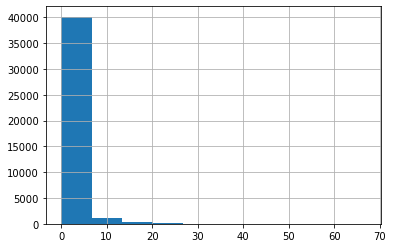

In [60]:
df_ds_1[df_ds_1['dato']!=0]['dato'].hist()

In [55]:

st = df_ds_1['codigo'].unique()

In [56]:
dfSt = pd.DataFrame({'codigo':st})

In [57]:
len(dfSt)

187

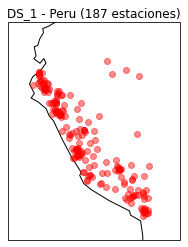

In [58]:
#Leemos un dato de imagen satelital para obtener las coordenadas
imagenTest = 'F:/GOES/C08/2021/01/G16_C08_Cyl_20210101-0020.nc'
ds = Dataset(imagenTest)
field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

# obtiene las coordenadas de los pixeles
lons = ds.variables['longitude'][:].data
lats = ds.variables['latitude'][:].data
lons, lats = np.meshgrid(lons, lats)


#Graficomos
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(f'DS_1 - Peru ({len(dfSt)} estaciones)')
ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

dfEstaciones = pd.read_csv(Festaciones)

for x in dfSt.index:
    st = dfEstaciones[dfEstaciones['CODE'] == f'X{dfSt["codigo"][x]}']    
    if not st.empty: 
        #print(st)
        x = st['LON']#.iloc[0]
        y = st['LAT']#.iloc[0]
        plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    
    
ax.coastlines(resolution='110m')
plt.savefig(f'{path_base}/Archivos/Reportes/MAPA_DS_01.png')
plt.show()